# Notes for "Deep Learning for Portfolio Optimization"

Reference Paper: [Deep Learning for Portfolio Optimization](https://arxiv.org/abs/2005.13665)

---

In [1]:
import omega as o
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

In [ ]:
def create_lstm_input(data, lookback_window):
    n_features = data.shape[1]
    n_samples = len(data) - lookback_window
    lstm_input = np.zeros((n_samples, lookback_window, n_features))
    for i in range(n_samples):
        lstm_input[i] = data.iloc[i:i + lookback_window].values
    return lstm_input

def create_lstm_target(data, lookback):
    n_samples = len(data) - lookback
    target_data = data.iloc[lookback:].values[:n_samples]
    return target_data

def objective(outputs, targets):
    portfolio_returns = (outputs * targets).sum(dim=1)
    mean_portfolio_return = portfolio_returns.mean() * 252
    mean_squared_portfolio_return = (portfolio_returns ** 2).mean() * (252 ** 2)
    denominator = torch.sqrt(mean_squared_portfolio_return - mean_portfolio_return ** 2)
    custom_objective_value = mean_portfolio_return / denominator
    return custom_objective_value

In [ ]:
start = '2006-02-06'
end = '2020-04-05'

indices = ['VTI', 'AGG', 'DBC', '^VIX']
prices = o.Ticker(indices).bulk_prices(start, end)
returns = np.log(prices).diff()[1:]

features = pd.concat([prices.loc[returns.index], returns], axis=1)
features.head(3)

,VTI,AGG,DBC,^VIX,VTI,AGG,DBC,^VIX
Date,,,,,,,,
2006-02-07,45.025761,58.835205,21.282080,13.59,-0.009784,-0.000699,-0.029352,0.041313
2006-02-08,45.349682,58.805824,21.191517,12.83,0.007168,-0.000499,-0.004264,-0.057548
2006-02-09,45.263290,58.841106,21.390757,13.12,-0.001907,0.000600,0.009358,0.022352


In [ ]:
lookback= 50

lstm_input  = create_lstm_input(features, lookback)
lstm_target = create_lstm_target(returns, lookback)

In [ ]:
class PortfolioOptimizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortfolioOptimizationNetwork, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last_time_step = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last_time_step)
        output = self.softmax(fc_out)
        return output

input_dim = lstm_input.shape[-1] # number of features
hidden_dim = 64
output_dim = lstm_target.shape[-1] # number of indices

In [ ]:
model = PortfolioOptimizationNetwork(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), maximize=True)

train_size = int(0.9 * len(lstm_input))

train_input = lstm_input[:252*2]
train_target = lstm_target[:252*2]

test_input = lstm_input[252*2:252*4]
test_target = lstm_target[252*2:252*4]

train_input_torch = torch.tensor(train_input, dtype=torch.float32)
train_target_torch = torch.tensor(train_target, dtype=torch.float32)

test_input_torch = torch.tensor(test_input, dtype=torch.float32)
test_target_torch = torch.tensor(test_target, dtype=torch.float32)
epochs = 100

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_input_torch)
    gain = objective(outputs, train_target_torch)
    gain.backward()
    optimizer.step()
    print(f'{gain.item()}', end='\r')

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Constants
lookback_window = 50
hidden_dim = 64
train_pct = 0.9
epochs = 100
two_year_days = 252 * 2  # Approximate number of trading days in two years

# Function to split data
def get_data(start, end):
    return lstm_input[start:end], lstm_target[start:end]

# Training and Validation (2006-2010)
model = PortfolioOptimizationNetwork(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), maximize=True)

for year_start in range(0, 252*4, two_year_days): # Assuming 4 years of training data
    # Get training data up to the current two-year period
    train_input, train_target = get_data(0, year_start + two_year_days)
    
    # Split into training and validation sets
    train_size = int(train_pct * len(train_input))
    train_input_torch = torch.tensor(train_input[:train_size], dtype=torch.float32)
    train_target_torch = torch.tensor(train_target[:train_size], dtype=torch.float32)
    validation_input_torch = torch.tensor(train_input[train_size:], dtype=torch.float32)
    validation_target_torch = torch.tensor(train_target[train_size:], dtype=torch.float32)
    
    # Train the model
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_input_torch)
        gain = objective(outputs, train_target_torch)
        gain.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}: Gain: {gain.item()}', end='\r')

    # Validate the model (optional)
    model.eval()
    with torch.no_grad():
        validation_outputs = model(validation_input_torch)
        validation_gain = objective(validation_outputs, validation_target_torch)
        print(f'Validation Gain: {validation_gain.item()}')

# Testing (2011-2020)
test_input, test_target = get_data(252*4, -1) # Assuming test data starts after 4 years
test_input_torch = torch.tensor(test_input, dtype=torch.float32)
test_target_torch = torch.tensor(test_target, dtype=torch.float32)

# Predict and evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(test_input_torch)
    test_gain = objective(test_outputs, test_target_torch)
    print(f'Test Gain: {test_gain.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Validation Gain: 0.14788074791431427591


  0%|          | 0/100 [00:00<?, ?it/s]

Validation Gain: 0.152076944708824169055
Test Gain: 0.05884596332907677


In [ ]:
model.eval()
test_in = torch.tensor(test_input, dtype=torch.float32)
with torch.no_grad():
    outputs = model(test_input_torch)

In [ ]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.0263,  0.0662, -0.0922,  ..., -0.0096,  0.0778, -0.0351],
                      [ 0.1062, -0.0681,  0.1286,  ..., -0.0698, -0.1252, -0.0673],
                      [ 0.1060,  0.1514,  0.0926,  ..., -0.0143, -0.0763, -0.1047],
                      ...,
                      [ 0.0650, -0.0290,  0.0812,  ...,  0.0448,  0.0145,  0.0438],
                      [-0.0073, -0.0106,  0.1232,  ...,  0.1399,  0.1991, -0.2194],
                      [ 0.1106, -0.0253,  0.1070,  ...,  0.0470, -0.0673, -0.0815]])),
             ('lstm.weight_hh_l0',
              tensor([[-0.0368,  0.0771,  0.0200,  ...,  0.0524,  0.0070, -0.0935],
                      [-0.0713, -0.1496,  0.0688,  ..., -0.0117, -0.0803,  0.0903],
                      [ 0.0715,  0.1082,  0.0875,  ..., -0.0796, -0.1010, -0.1112],
                      ...,
                      [ 0.0120,  0.0258, -0.0535,  ...,  0.0474,  0.0982, -0.0170],
                      [ 0.0133,  

In [ ]:
outputs.shape

torch.Size([352, 4])

In [ ]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.0317,  0.0200,  0.0781,  ..., -0.0418, -0.0418,  0.0728],
                      [-0.0613,  0.1339,  0.0087,  ..., -0.0523, -0.0477,  0.1550],
                      [ 0.0607,  0.1139,  0.0735,  ..., -0.0151, -0.0879,  0.0865],
                      ...,
                      [ 0.1221,  0.1087,  0.0047,  ..., -0.0987,  0.2664, -0.0358],
                      [ 0.1722,  0.0064, -0.0481,  ..., -0.2229,  0.2174, -0.1269],
                      [ 0.1005, -0.0564,  0.0806,  ...,  0.0094, -0.1233,  0.1002]])),
             ('lstm.weight_hh_l0',
              tensor([[-0.1235,  0.0907, -0.1100,  ..., -0.0173,  0.1334, -0.1530],
                      [-0.0811, -0.0307, -0.0460,  ...,  0.0785,  0.0400, -0.1109],
                      [ 0.0939, -0.0233, -0.0817,  ...,  0.0068, -0.1023, -0.0618],
                      ...,
                      [-0.1711,  0.0885,  0.0976,  ...,  0.0685, -0.0470,  0.0560],
                      [-0.0181,  

<Axes: xlabel='Date'>

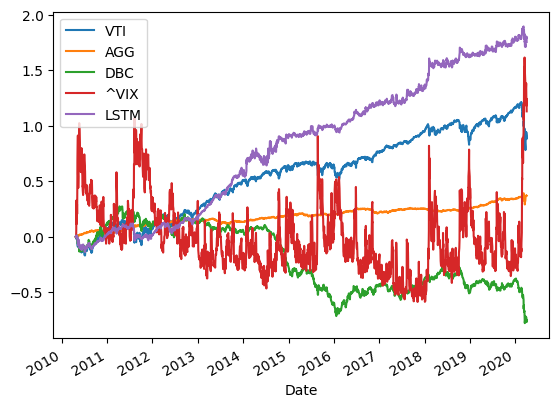

In [ ]:
model_rets = pd.DataFrame(test_outputs * test_target).sum(axis=1)
comparison = returns[-len(model_rets):].copy()
comparison['LSTM'] = model_rets.values
comparison = comparison.shift()
comparison.iloc[0] = 0
comparison.cumsum().plot()

In [ ]:
class PortfolioOptimizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortfolioOptimizationNetwork, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last_time_step = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last_time_step)
        output = self.softmax(fc_out)
        return output

class LSTMPortfolioOptimizer:

    def __init__(self, prices, lookback=50, train_pct=.8, hidden_dim=50):
        self.prices = prices
        self.returns = np.log(self.prices).diff()[1:]
        self.features = pd.concat([self.prices.loc[self.returns.index], self.returns], axis=1)
        self.lookback = lookback
        self.train_pct = train_pct
        self.hidden_dim = hidden_dim
        self._init()

    def train(self, epochs=100):
        self.model = PortfolioOptimizationNetwork(self.input_dim, self.hidden_dim, self.output_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), maximize=True)
        for epoch in tqdm(range(epochs)):
            self.model.train()
            self.optimizer.zero_grad()
            outputs = self.model(self.train_input_torch)
            gain = self.objective(outputs, self.train_target_torch)
            gain.backward()
            self.optimizer.step()
            print(f'Epoch {epoch+1}/{epochs}: Gain: {gain.item()}', end='\r')

            self.model.eval()
            with torch.no_grad():
                self.weights = self.model(self.test_input_torch)

            self.test_returns = self.weights * self.test_target
        
    def _init(self):
        self.input = self.create_lstm_input(self.features, self.lookback)
        self.target = self.create_lstm_target(self.returns, self.lookback)
        self.train_size = int(self.train_pct * len(self.input))
        self.train_input = self.input[:self.train_size]
        self.train_target = self.target[:self.train_size]
        self.test_input = self.input[self.train_size:]
        self.test_target = self.target[self.train_size:]
        self.input_dim = self.input.shape[-1]
        self.output_dim = self.target.shape[-1]
        self.train_input_torch = torch.tensor(self.train_input, dtype=torch.float32)
        self.train_target_torch = torch.tensor(self.train_target, dtype=torch.float32)
        self.test_input_torch = torch.tensor(self.test_input, dtype=torch.float32)
        self.test_target_torch = torch.tensor(self.test_target, dtype=torch.float32)

    @staticmethod
    def create_lstm_input(data, lookback_window):
        n_features = data.shape[1]
        n_samples = len(data) - lookback_window
        lstm_input = np.zeros((n_samples, lookback_window, n_features))
        for i in range(n_samples):
            lstm_input[i] = data.iloc[i:i + lookback_window].values
        return lstm_input

    @staticmethod
    def create_lstm_target(data, lookback):
        n_samples = len(data) - lookback
        target_data = data.iloc[lookback:].values[:n_samples]
        return target_data

    @staticmethod
    def objective(outputs, targets):
        portfolio_returns = (outputs * targets).sum(dim=1)
        mean_portfolio_return = portfolio_returns.mean()
        mean_squared_portfolio_return = (portfolio_returns ** 2).mean()
        denominator = torch.sqrt(mean_squared_portfolio_return - mean_portfolio_return ** 2)
        custom_objective_value = mean_portfolio_return / denominator
        return custom_objective_value

In [ ]:
po = LSTMPortfolioOptimizer(prices, lookback=50, train_pct=0.8, hidden_dim=50)

In [ ]:
po.train(epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='Date'>

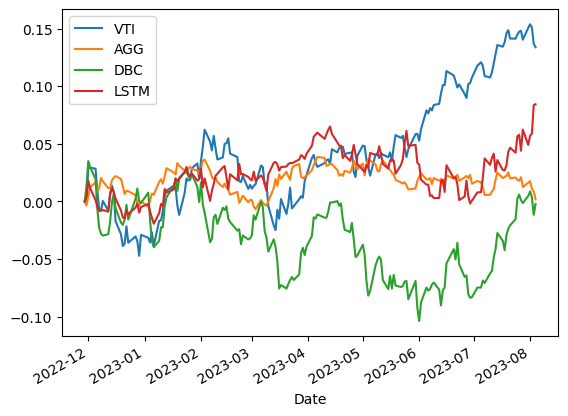

In [ ]:
model_returns = pd.DataFrame(po.test_returns).sum(axis=1)
comparison = po.returns[-len(model_returns):].copy()
comparison['LSTM'] = model_returns.values
comparison = comparison.drop(columns='^VIX')
comparison = comparison.shift()
comparison.loc[comparison.index.min()] = 0
comparison.cumsum().plot()

In [ ]:
comparison.cumsum()

,VTI,AGG,DBC,LSTM
Date,,,,
2022-11-29,0.000000,0.000000,0.000000,0.000000
2022-11-30,-0.001565,-0.003582,0.012919,-0.004539
2022-12-01,0.028784,0.004180,0.035133,-0.009700
2022-12-02,0.029372,0.012467,0.030020,-0.019512
2022-12-05,0.028441,0.016605,0.019317,-0.036217
...,...,...,...,...
2023-07-31,0.150857,0.016406,0.004800,0.087852
2023-08-01,0.153883,0.017635,0.008860,0.097892
2023-08-02,0.151165,0.010992,0.003579,0.102062
